# Stock Market Sentiment Analysis

The following Python project aims to retreive a number of articles using the Google News 

In [83]:
# Load necessary packages

import requests
import json
import pandas as pd
import os
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy as sp
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from pandas_market_calendars import get_calendar
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_market_calendars import get_calendar
import glob

We first set important global variables, such as the date of today.

In [84]:
today = datetime.date.today()
nlp = sp.load("en_core_web_sm")
current_directory = os.getcwd()
os.chdir(current_directory)

# Pipeline

In [40]:
def fetch_articles(category, start_date, end_date):
    """
    Fetches articles from the specified category within the given date range using the GNews API.

    Parameters:
    - category (str): The category of articles to fetch.
    - start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
    - end_date (str): The end date of the date range in 'YYYY-MM-DD' format.

    Returns:
    - list: A list of dictionaries representing the fetched articles.
    """
    
    api_key = '88edd99823231ee937f06064cd930842'
    url = f"https://gnews.io/api/v4/top-headlines?category={category}&from={start_date}&to={end_date}&lang=en&country=us&max=100&apikey={api_key}"
    response = requests.get(url)
    articles = json.loads(response.text)['articles']
    return articles

In [41]:
def calculate_sentiment_scores(text):
    """
    Calculates sentiment scores for the given text using the VADER sentiment analysis tool.

    Parameters:
    - text (str): The text for which sentiment scores are to be calculated.

    Returns:
    - dict: A dictionary containing sentiment scores (neg, neu, pos, compound).
    """
    
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [87]:
def export_sentiment_data(sentiment_scores):
    """
    Exports sentiment scores data to a CSV file.

    Parameters:
    - sentiment_scores (dict): A dictionary containing sentiment scores for articles.

    Returns:
    - None
    """

    # Convert data to list of dictionaries
    data_list = []
    for title, scores in sentiment_scores.items():
        row = {'date': today, 'title': title, **scores}
        data_list.append(row)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data_list)
    
    # Define CSV file name
    csv_file_name = f"sentiment_scores_{today}.csv"

    # Export DataFrame to CSV file
    df.to_csv(csv_file_name, index=False)

    print(f"Data has been exported to '{csv_file_name}' successfully.")

In [86]:
def concat_csv():
    """
    Concatenates all CSV files in the current directory starting with 'sentiment_scores' row by row.

    Returns:
    - pd.DataFrame: A DataFrame containing the concatenated data from all CSV files.
    """
    # Get a list of all CSV files starting with 'sentiment_scores' in the current directory
    csv_files = glob.glob('sentiment_scores*.csv')

    # Initialize an empty list to store DataFrames from each CSV file
    dfs = []

    # Iterate over each CSV file and read it into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)

    # Concatenate all DataFrames row by row
    concatenated_df = pd.concat(dfs, ignore_index=True)

     # Export the concatenated DataFrame to a CSV file
    concatenated_df.to_csv('all_sentiment_scores.csv', index=False)

    return concatenated_df


In [88]:
def get_sp500_price(start, end):
    """
    Get the adjusted close price of the S&P 500 index from Yahoo Finance for a specific date.
    If the given date is not a trading day for the S&P 500, return the price for the last trading day.

    Parameters:
    - date (str): Date in 'YYYY-MM-DD' format for which to retrieve the price.

    Returns:
    - float: Adjusted close price of the S&P 500 on the specified date or the last trading day.
    """
    # Define the ticker symbol for the S&P 500 index
    sp500_ticker = '^GSPC'  # S&P 500 index ticker symbol

    # Check if the given date is a trading day for the S&P 500
    sp500_calendar = get_calendar('NYSE')
    if not sp500_calendar.valid_days(start_date=start, end_date=end).empty:
        # If the given date is a trading day, fetch historical data for the S&P 500 index from Yahoo Finance
        sp500_data = yf.download(sp500_ticker, start=start, end=end)
        # Extract the adjusted close price for the specified date
        sp500_price = sp500_data['Adj Close'][0]
    else:
        # If the given date is not a trading day, find the last trading day and get the price for that day instead
        last_trading_day = sp500_calendar.previous_trading_day(start)
        sp500_data_last = yf.download(sp500_ticker, start=last_trading_day, end=last_trading_day)
        sp500_price = sp500_data_last['Adj Close'][0]

    return sp500_price

# Example usage:
start = '2022-04-05'  # Input date in 'YYYY-MM-DD' format
end = '2022-04-06'  # Input date in 'YYYY-MM-DD' format
sp500_price = get_sp500_price(start, end)
print(f"The adjusted close price of the S&P 500 on {date} was: ${sp500_price:.2f}")


[*********************100%***********************]  1 of 1 completed
The adjusted close price of the S&P 500 on 2022-04-05 was: $4525.12


# Retreive articles

Using the API of Google News, we retrieve the maximum possible number of business news for today.

In [69]:
# Load all possible articles for today
category = "business"
articles = fetch_articles(category, today, today)

# Extract both the title and the description component of all articles
descriptions = [article['description'] for article in articles]

# Calculate sentiment score
Using Vader, we calculate the sentiment score for each article, as well as the given day in total.
We also retrive the daily market price for the S&P 500 and save the data together in a CSV file for each day.

In [89]:
sentiment_scores = {}
total_sentiment = {
    'neg': 0,
    'pos': 0,
    'neu': 0,
    'compound': 0
}

# Text preprocessing and sentiment score calculation
for article in articles:
    current_score = calculate_sentiment_scores(article['description'])
    sentiment_scores[article['title']] = current_score
    total_sentiment['neg'] += current_score['neg']
    total_sentiment['pos'] += current_score['pos']
    total_sentiment['neu'] += current_score['neu']
    total_sentiment['compound'] += current_score['compound']

for key, value in sentiment_scores.items():
    print(key, ':', value)

# Calculating the total sentiment scores for today
num_articles = len(sentiment_scores)
total_sentiment['neg'] /= num_articles
total_sentiment['neu'] /= num_articles
total_sentiment['pos'] /= num_articles
total_sentiment['compound'] /= num_articles

print(total_sentiment)

# Getting today's SP500 price and saving 
sp500 = get_sp500_price(today, today + datetime.timedelta(days=1))
export_sentiment_data(sentiment_scores)

From $1,000 in savings to bringing in $25M/year : {'neg': 0.205, 'neu': 0.737, 'pos': 0.059, 'compound': -0.655}
It may not be long before Arbitrum outshines Ethereum, but only if… : {'neg': 0.057, 'neu': 0.648, 'pos': 0.295, 'compound': 0.7089}
Insurance Companies Reap Hidden Fees as Patients Get Unexpected Bills : {'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'compound': 0.3818}
What’s wrong with Tesla : {'neg': 0.257, 'neu': 0.743, 'pos': 0.0, 'compound': -0.91}
California could become first state to give workers a ‘right to disconnect’ : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Cleveland Hopkins airport plane crash and fire : {'neg': 0.175, 'neu': 0.825, 'pos': 0.0, 'compound': -0.6249}
Plane crashes at Cleveland Hopkins International Airport : {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}
Airfield reopens after planes diverted from Cleveland Hopkins International Airport for plane crash : {'neg': 0.095, 'neu': 0.905, 'pos': 0.0, 'compound': -0.2263}
Is the 

IndexError: index 0 is out of bounds for axis 0 with size 0

# Diagrams & Results
Creating a Scatterplot comparing the sentiment of the individual articles.

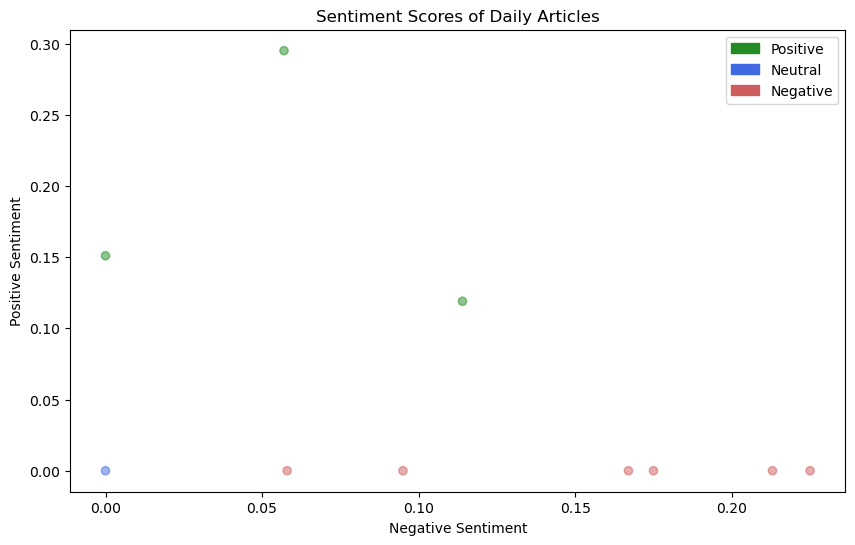

In [24]:
# Separate data for plotting
x = [article['neg'] for article in sentiment_scores.values()]
y = [article['pos'] for article in sentiment_scores.values()]
colors = ['forestgreen' if article['compound'] > 0 else 'royalblue' if article['compound'] == 0 else 'indianred' for article in sentiment_scores.values()]

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Negative Sentiment')
plt.ylabel('Positive Sentiment')

# Customize legend
green_patch = mpatches.Patch(color='forestgreen', label='Positive')
blue_patch = mpatches.Patch(color='royalblue', label='Neutral')
red_patch = mpatches.Patch(color='indianred', label='Negative')

# Additional plot settings
plt.legend(handles=[green_patch, blue_patch, red_patch], loc='upper right', fontsize='medium')
plt.grid(False)
plt.show()


Creating a Heatmap comparing each sentiment score (incl. compounded) of the individual articles by title.

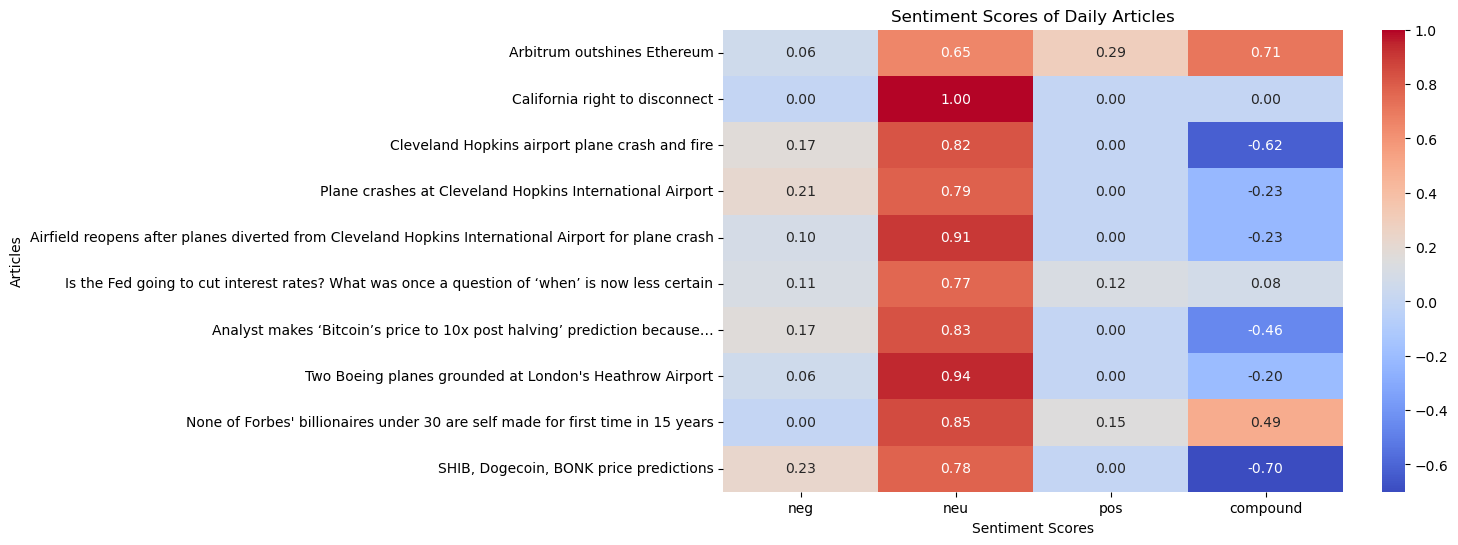

In [25]:
# Create DataFrame based on the data
df = pd.DataFrame(sentiment_scores).T

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['neg', 'neu', 'pos', 'compound']], cmap='coolwarm', annot=True, fmt=".2f")

# Additional plot settings
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Sentiment Scores')
plt.ylabel('Articles')
plt.show()


Creating a bar plot displaying the relative sentiment of the market, displayed as the ratio of positive and negative sentiments.

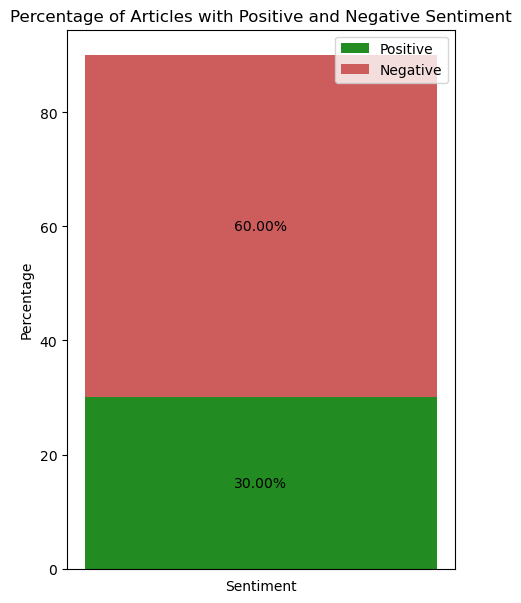

In [30]:
# Count positive and negative articles
positive_count = sum(1 for score in sentiment_scores.values() if score['compound'] > 0)
negative_count = sum(1 for score in sentiment_scores.values() if score['compound'] < 0)

# Calculate percentages
total_articles = len(sentiment_scores)
positive_percent = (positive_count / total_articles) * 100
negative_percent = (negative_count / total_articles) * 100

plt.figure(figsize=(5, 7))
plt.bar([0.5], [positive_percent], color='forestgreen', label='Positive')
plt.bar([0.5], [negative_percent], color='indianred', bottom=positive_percent, label='Negative')

# Add text labels
plt.text(0.5, positive_percent / 2, f'{positive_percent:.2f}%', ha='center', va='center')
plt.text(0.5, positive_percent + (negative_percent / 2), f'{negative_percent:.2f}%', ha='center', va='center')

# Additional plot settings
plt.title('Percentage of Articles with Positive and Negative Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks([])
plt.legend()
plt.show()


# Historic Data & Trend Analysis
In this step, we concat all persisted historic sentiment scores and market prices into a new CSV data.

In [ ]:
concatenated = concat_csv()

We display the trend using a line chart.